In [259]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

In [260]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')
sub_train = train

# Feature 설명

index   
gender: 성별   
car: 차량 소유 여부   
reality: 부동산 소유 여부   
child_num: 자녀 수   
income_total: 연간 소득   
income_type: 소득 분류   
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   
edu_type: 교육 수준   
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']   
family_type: 결혼 여부   
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']   
house_type: 생활 방식   
['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']   
DAYS_BIRTH: 출생일   
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   
DAYS_EMPLOYED: 업무 시작일   
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   
FLAG_MOBIL: 핸드폰 소유 여부   
work_phone: 업무용 전화 소유 여부   
phone: 전화 소유 여부   
email: 이메일 소유 여부   
occyp_type: 직업 유형	   												
family_size: 가족 규모   
begin_month: 신용카드 발급 월 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미   

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함   



# Preprocessing

## 1. DAYS_EMPLOYED

In [261]:
train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()


365243    4438
Name: DAYS_EMPLOYED, dtype: int64

In [262]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

<AxesSubplot:ylabel='Frequency'>

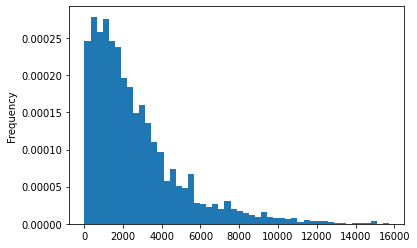

In [263]:
abs(train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED']).plot(kind='hist',bins=50,density=True)

In [264]:
train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
train['DAYS_EMPLOYED']

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 26457, dtype: int64

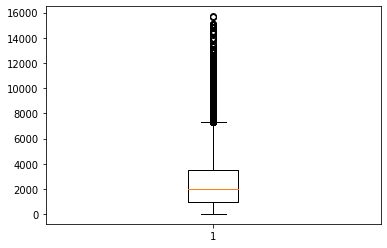

In [265]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [266]:
Q1 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.25))
Q2 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.50))
Q3 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.75))
IQR = Q3 - Q1

print(f'Q1 : {Q1} Q3 : {Q3} IQR : {IQR}')

Q1 : 969.5 Q3 : 3506.0 IQR : 2536.5


In [267]:
train.loc[(train['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (train['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3

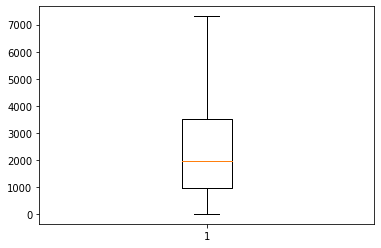

In [268]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [269]:
def dayEMP_category(day_ep):
    ep = ''
    if day_ep == 0: ep = 0
    elif day_ep <= Q1: ep = 1
    elif day_ep <= Q2: ep = 2
    elif day_ep <= Q3: ep = 3
    elif day_ep > Q3: ep = 4
       
    return ep


In [270]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x : dayEMP_category(x))

In [271]:
train['DAYS_EMPLOYED'].value_counts()

3    6763
2    5506
1    5505
0    4438
4    4245
Name: DAYS_EMPLOYED, dtype: int64